## IMPORT DEPENDENCIES

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
from torchvision.models import resnet18
from tqdm import tqdm
import math
import torch.autograd as autograd
import numpy as np
from torch.utils.data import Subset
import psutil
import time
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DOWNLOAD and TRANSFORM CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Function to sample 20% data from each class
def rand_sample(dataset, fraction=0.2):
    targets = np.array(dataset.targets)  # Get labels
    indices = np.arange(len(dataset))   # Get all indices
    selected_indices = []               # Store selected indices

    num_classes = len(set(targets))  # CIFAR-10 has 10 classes

    for class_idx in range(num_classes):
        class_indices = indices[targets == class_idx]  # Get indices of current class
        sampled_indices = np.random.choice(class_indices, int(len(class_indices) * fraction), replace=False)
        selected_indices.extend(sampled_indices)

    return selected_indices

# training fraction
train_indices = rand_sample(train_dataset, fraction = 0.2)

# testing fraction
test_indices = rand_sample(test_dataset, fraction = 1)

# Create subsets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_subset, batch_size=256, shuffle=False, num_workers=4)


100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## CUSTOM SUBNET CONVOLUTION LAYER

In [3]:
############## GIVE SUBNET BASED ON SCORE i.e. Take TOP K and Prune the rest######################
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None


#################################### CONVULATION TYPE ################################################
# Not learning weights, finding subnet based on top k score values
class SubnetConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        self.use_subset = True

        self.score_mask = None

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    def init_weight_with_score(self, prune_rate):
        self.weight.data = self.weight.data * GetSubnet.apply(self.clamped_scores, prune_rate).data
        self.use_subset = False

    @property
    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return GetSubnet.apply(self.clamped_scores, self.prune_rate).detach()

    def forward(self, x):
        if self.use_subset:
            subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
            w = self.weight * subnet
        else:
            w = self.weight

        x = F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

        return x
    
    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet()  # Get the mask (subnetwork)
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params
    
    
class SubnetConv_row(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()[:3]))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        self.use_subset = True
        
    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    def init_weight_with_score(self, prune_rate):
        self.weight.data = self.weight.data * GetSubnet.apply(self.clamped_scores, prune_rate).view(self.weight.size()[0], self.weight.size()[1], self.weight.size()[2], 1).data
        self.use_subset = False

    @property
    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return GetSubnet.apply(self.clamped_scores, self.prune_rate).detach()

    def forward(self, x):
        if self.use_subset:
            subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
            w = self.weight * subnet.view(self.weight.size()[0], self.weight.size()[1], self.weight.size()[2], 1)
        else:
            w = self.weight

        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x
    
    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet() 
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params

class SubnetConv_kernel(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()[:2]))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        self.use_subset = True

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    def init_weight_with_score(self, prune_rate):
        self.weight.data = self.weight.data * GetSubnet.apply(self.clamped_scores, prune_rate).view(self.weight.size()[0], self.weight.size()[1], 1, 1).data
        self.use_subset = False
        
    @property
    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return GetSubnet.apply(self.clamped_scores, self.prune_rate).detach()

    def forward(self, x):
        if self.use_subset:
            subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
            w = self.weight * subnet.view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        else:
            w = self.weight

        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x
    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet()  # Get the mask (subnetwork)
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params

class FixedSubnetConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate
        print("prune_rate_{}".format(self.prune_rate))

    def set_subnet(self):
        output = self.clamped_scores().clone()
        _, idx = self.clamped_scores().flatten().abs().sort()
        p = int(self.prune_rate * self.clamped_scores().numel())
        flat_oup = output.flatten()
        flat_oup[idx[:p]] = 0
        flat_oup[idx[p:]] = 1
        self.scores = torch.nn.Parameter(output)
        self.scores.requires_grad = False

    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return self.weight * self.scores

    def forward(self, x):
        w = self.get_subnet()
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

    def count_nonzero_params(self):
        """Counts and returns the number of non-zero and total parameters."""
        total_params = self.weight.numel()  # Total number of parameters (before pruning)

        if self.prune_rate > 0:
            subnet = self.get_subnet()  # Get the mask (subnetwork)
            non_zero_params = (subnet != 0).sum().item()  # Count non-zero parameters after pruning
        else:
            non_zero_params = total_params  # If no pruning, all parameters are used

        return non_zero_params, total_params


#################################### BATCH NORMALIZATION TYPE ################################################ 
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

## UTILITY FUNCTION FOR INITIALIZATION METHOD

In [4]:
def _calculate_fan_in_and_fan_out(tensor):
    dimensions = tensor.dim()
    if dimensions < 2:
        raise ValueError("Fan in and fan out cannot be computed for tensor with fewer than 2 dimensions")

    num_input_fmaps = tensor.size(1)
    num_output_fmaps = tensor.size(0)
    receptive_field_size = 1
    if tensor.dim() > 2:
        for s in tensor.shape[2:]:
            receptive_field_size *= s
    fan_in = num_input_fmaps * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size

    return fan_in, fan_out


def _calculate_correct_fan(tensor, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError(f"Mode {mode} not supported, please use one of {valid_modes}")
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out


def calculate_gain(nonlinearity, param=None):
    if nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'linear' or nonlinearity == 'conv2d':
        return 1.0
    elif nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        else:
            negative_slope = param
        return math.sqrt(2.0 / (1 + negative_slope ** 2))
    else:
        raise ValueError(f"Unsupported nonlinearity: {nonlinearity}")


def signed_constant(tensor, mode='fan_in', nonlinearity='relu', scale_fan=False, prune_rate=0.0):
    fan = _calculate_correct_fan(tensor, mode)
    if scale_fan:
        fan = fan * (1 - prune_rate)
    gain = calculate_gain(nonlinearity)
    std = gain / math.sqrt(fan)
    with torch.no_grad():
        tensor.data = tensor.sign() * std

    return tensor

## RESNET BLOCK

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, prune_rate=0.5, conv_layer=None):
        super(BasicBlock, self).__init__()
        assert conv_layer is not None, "conv_layer must be provided"
        
        self.conv_layer = conv_layer 

        self.conv1 = self.conv_layer(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv1.set_prune_rate(prune_rate)
        self.bn1 = NonAffineBatchNorm(planes)

        self.conv2 = self.conv_layer(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2.set_prune_rate(prune_rate)
        self.bn2 = NonAffineBatchNorm(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                self.conv_layer(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                NonAffineBatchNorm(self.expansion * planes)
            )
            self.shortcut[0].set_prune_rate(prune_rate)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, prune_rate=0.5, conv_layer=None):
        super(Bottleneck, self).__init__()
        assert conv_layer is not None, "conv_layer must be provided"

        self.conv_layer = conv_layer 

        self.conv1 = self.conv_layer(in_planes, planes, kernel_size=1, bias=False)
        self.conv1.set_prune_rate(prune_rate)
        self.bn1 = NonAffineBatchNorm(planes)

        self.conv2 = self.conv_layer(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2.set_prune_rate(prune_rate)
        self.bn2 = NonAffineBatchNorm(planes)

        self.conv3 = self.conv_layer(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.conv3.set_prune_rate(prune_rate)
        self.bn3 = NonAffineBatchNorm(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                self.conv_layer(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                NonAffineBatchNorm(self.expansion * planes)
            )
            self.shortcut[0].set_prune_rate(prune_rate)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, prune_rate=0.5, initialization_method='kaiming_constant', conv_layer=None):
        super(ResNet, self).__init__()
        assert conv_layer is not None, "conv_layer must be provided"

        self.in_planes = 64
        self.prune_rate = prune_rate
        self.conv_layer = conv_layer 

        self.conv1 = self.conv_layer(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1.set_prune_rate(prune_rate)
        self.bn1 = NonAffineBatchNorm(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, prune_rate=prune_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, prune_rate=prune_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, prune_rate=prune_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, prune_rate=prune_rate)

        self.linear = nn.Linear(512*block.expansion, num_classes)
        
        # Initialize Weight 
        if initialization_method == "kaiming_constant":
            print("======> Initializing Weight with Signed Kaiming Constant")
            self.kaiming_constant()            
        elif initialization_method == "kaiming_uniform":
            print("======> Initializing Weight with Kaiming Uniform")
            self.kaiming_uniform()
        elif initialization_method == "kaiming_normal":
            print("======> Initializing Weight with Kaiming Normal")
            self.kaiming_normal()
        elif initialization_method == "xavier_normal":
            print("======> Initializing Weight with Xavier Normal")
            self.xavier_normal()
        else:
            print("Choose a valid Initialization Method !!!!!!!!!")
            exit()

    def _make_layer(self, block, planes, num_blocks, stride, prune_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, prune_rate, conv_layer=self.conv_layer))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
    # Initialization methods
    def kaiming_constant(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                signed_constant(m.weight, mode='fan_in', nonlinearity='relu', scale_fan=False, prune_rate=self.prune_rate)
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                signed_constant(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def kaiming_uniform(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def kaiming_normal(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                fan_in = _calculate_correct_fan(m.weight, mode='fan_in')
                fan_in_scaled = fan_in * (1 - self.prune_rate)
                gain = calculate_gain('relu')
                std = gain / math.sqrt(fan_in_scaled)
                with torch.no_grad():
                    m.weight.normal_(0, std)
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def xavier_normal(self):
        for m in self.modules():
            if isinstance(m, self.conv_layer):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, NonAffineBatchNorm):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def count_total_params(self):
        """Counts and prints the total number of non-zero and total parameters after pruning."""
        total_non_zero_params = 0
        total_params = 0

        for name, module in self.named_modules():
            if isinstance(module, self.conv_layer):
                non_zero_params, layer_total_params = module.count_nonzero_params()
                total_non_zero_params += non_zero_params
                total_params += layer_total_params

                print(f"{name}: {non_zero_params} out of {layer_total_params} parameters are non-zero")

        print(f"Total non-zero parameters after pruning: {total_non_zero_params}")
        print(f"Total parameters before pruning: {total_params}")


def ResNet18(prune_rate, initialization_method, conv_layer):
    return ResNet(BasicBlock, [2, 2, 2, 2], prune_rate=prune_rate, initialization_method=initialization_method, conv_layer=conv_layer)

In [6]:
def freeze_model_scores(model):
    for n, m in model.named_modules():
        if hasattr(m, "scores"):
            m.scores.requires_grad = False
            print(f"==> No gradient to {n}.scores")
            if m.scores.grad is not None:
                print(f"==> Setting gradient of {n}.scores to None")
                m.scores.grad = None


def load_model(prune_rate, initialization_method, conv_layer):
    # Load checkpoint
    checkpoint = torch.load(f'/kaggle/input/new-model-data/pgd_adversarial_training_kaiming_constant_best_{prune_rate}.pth')
    
    # Clean the keys to remove 'module.' prefix
    from collections import OrderedDict
    
    new_state_dict = OrderedDict()
    for k, v in checkpoint['net'].items():
        name = k.replace('module.', '')  # remove 'module.' if it exists
        new_state_dict[name] = v
    
    # Load into model
    model = ResNet18(prune_rate, initialization_method, conv_layer)
    
    model.load_state_dict(new_state_dict)
    for n, m in model.named_modules():
        if isinstance(m, FixedSubnetConv):
            m.set_subnet()
    print("Model weights loaded successfully!")

    return model

def get_model(prune_rate, initialization_method, conv_layer):
    print(f"=======> Re-training Start")
    print("=> Loading Model")
    model = load_model(prune_rate, initialization_method, conv_layer)
    
    print("=> Freezing model score")
    freeze_model_scores(model)

    model.count_total_params()
    return model


## PGD, TRAIN, TEST FUNCTION

In [7]:
class LinfPGDAttack(object):
    def __init__(self, model):
        self.model = model
        self.epsilon = 8/256.
        self.alpha = 2/256.
        
    def perturb(self, x_natural, y, k):
        x = x_natural.detach()
        x = x + torch.zeros_like(x).uniform_(-self.epsilon, self.epsilon)
        for i in range(k):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = F.cross_entropy(logits, y)
            grad = torch.autograd.grad(loss, [x])[0]
            x = x.detach() + self.alpha * torch.sign(grad.detach())
            x = torch.min(torch.max(x, x_natural - self.epsilon), x_natural + self.epsilon)
            x = torch.clamp(x, 0, 1)
        return x


def train(train_loader, epoch, adversary, criterion, optimizer):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batches"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        adv = adversary.perturb(inputs, targets, 7)
        adv_outputs = net(adv)
        loss = criterion(adv_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = adv_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        

    print('\nTotal adversarial train accuarcy:', 100. * correct / total)
    print('Total adversarial train loss:', train_loss)

best_robust_acc = 0
def test(test_loader, epoch, adversary, criterion, optimizer):
    global best_robust_acc
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing Batches"):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            benign_loss += loss.item()

            _, predicted = outputs.max(1)
            benign_correct += predicted.eq(targets).sum().item()

            adv = adversary.perturb(inputs, targets, 20)
            adv_outputs = net(adv)
            loss = criterion(adv_outputs, targets)
            adv_loss += loss.item()

            _, predicted = adv_outputs.max(1)
            adv_correct += predicted.eq(targets).sum().item()

    print('\nTotal natural test accuarcy:', 100. * benign_correct / total)
    print('Total robust test Accuarcy:', 100. * adv_correct / total)
    print('Total natural test loss:', benign_loss)
    print('Total robust test loss:', adv_loss)
    if adv_correct > best_robust_acc:
        best_robust_acc = adv_correct  # Update best robust accuracy
        state = {
            'net': net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/{file_name}_best_{prune_rate}.pth')
        with open(f'{file_name}_accuracy_log_{prune_rate}.txt', 'a') as f:
            f.write(f'Epoch {epoch}: Natural Acc {100. * benign_correct / total}: Robust Accuracy = {100. * adv_correct / total}%\n')
        print('Model Saved!')


def adjust_learning_rate(learning_rate, optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


## DRIVER CODE

In [8]:
def get_memory_usage():
    process = psutil.Process()
    cpu_memory = process.memory_info().rss / 1024 ** 2  # in MB

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 ** 2
        gpu_reserved = torch.cuda.memory_reserved() / 1024 ** 2
        gpu_peak = torch.cuda.max_memory_allocated() / 1024 ** 2
    else:
        gpu_memory = gpu_reserved = gpu_peak = 0.0

    return cpu_memory, gpu_memory, gpu_reserved, gpu_peak
report = []

initialization_method = "kaiming_constant" # ['kaiming_constant', 'kaiming_uniform', 'kaiming_normal', 'xavier_normal']
sparsity_pattern = FixedSubnetConv # SubnetConv SubnetConv_row SubnetConv_kernel
file_name = f'pgd_adversarial_training_{initialization_method}'
learning_rate = 0.1
epochs = 10
prune_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# prune_rates = [0.05]

for prune_rate in prune_rates:
    best_robust_acc = 0
    net = get_model(prune_rate = prune_rate, initialization_method = initialization_method, conv_layer = sparsity_pattern)
    
    net = net.to(device)
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

    adversary = LinfPGDAttack(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Tracking time and memory
    torch.cuda.reset_peak_memory_stats()
    start_time = time.perf_counter()
    
    for epoch in range(0, epochs):
        adjust_learning_rate(learning_rate, optimizer, epoch)
        train(train_loader, epoch, adversary, criterion, optimizer)
        test(test_loader, epoch, adversary, criterion, optimizer)

    end_time = time.perf_counter()
    cpu_mem, gpu_mem, gpu_reserved, gpu_peak = get_memory_usage()

    report.append({
        "prune_rate": prune_rate,
        "total_time_sec": end_time - start_time,
        "avg_time_per_epoch_sec": (end_time - start_time) / 100,
        "cpu_mem_MB": cpu_mem,
        "gpu_mem_MB": gpu_mem,
        "gpu_reserved_MB": gpu_reserved,
        "gpu_peak_MB": gpu_peak,
    })
    
df = pd.DataFrame(report)
os.makedirs("logs", exist_ok=True)
df.to_csv("logs/prune_rate_training_report.csv", index=False)

print("Report saved to logs/prune_rate_training_report.csv")

=======> Re-training Start
=> Loading Model


<ipython-input-6-bf00eb3c9b30>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'/kaggle/input/new-model-data/pgd_adversarial_training_kaiming_cons

prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
prune_rate_0.1
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No gradient to layer2.1.conv2.scores
==> No gradient to layer3.0.conv1.scores
==> No gradient to layer3.0.conv2.scores
==> No gradient to layer3.0.shortcut.0.scores
==> No gradient to layer3.1.conv1.scores
==> No gr

Training Batches: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


Total adversarial train accuarcy: 9.29
Total adversarial train loss: 165.01806139945984

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 16.65
Total robust test Accuarcy: 13.34
Total natural test loss: 91.64338445663452
Total robust test loss: 99.68421602249146
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 15.92
Total adversarial train loss: 92.67810916900635

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Total natural test accuarcy: 13.03
Total robust test Accuarcy: 10.93
Total natural test loss: 104.65050667524338
Total robust test loss: 115.66068255901337

[ Train epoch: 2 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 15.79
Total adversarial train loss: 91.43324542045593

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 24.08
Total robust test Accuarcy: 18.51
Total natural test loss: 82.58907842636108
Total robust test loss: 87.62727618217468
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 18.05
Total adversarial train loss: 87.85816884040833

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 26.84
Total robust test Accuarcy: 19.91
Total natural test loss: 78.4584710597992
Total robust test loss: 86.24526011943817
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 18.66
Total adversarial train loss: 86.16780376434326

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 23.13
Total robust test Accuarcy: 18.15
Total natural test loss: 79.40408170223236
Total robust test loss: 88.3780288696289

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 20.5
Total adversarial train loss: 85.22957706451416

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 26.19
Total robust test Accuarcy: 18.56
Total natural test loss: 77.05608797073364
Total robust test loss: 87.47300016880035

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 21.07
Total adversarial train loss: 85.52812254428864

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 25.06
Total robust test Accuarcy: 14.85
Total natural test loss: 94.4074809551239
Total robust test loss: 116.88926911354065

[ Train epoch: 7 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 19.78
Total adversarial train loss: 86.62362170219421

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 28.16
Total robust test Accuarcy: 19.11
Total natural test loss: 77.53681969642639
Total robust test loss: 89.66261410713196

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 20.68
Total adversarial train loss: 84.34101891517639

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 30.35
Total robust test Accuarcy: 20.95
Total natural test loss: 77.82230317592621
Total robust test loss: 93.24928200244904
Model Saved!

[ Train epoch: 9 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.41
Total adversarial train loss: 83.0571266412735

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 26.02
Total robust test Accuarcy: 18.08
Total natural test loss: 83.4344619512558
Total robust test loss: 101.0347011089325
=======> Re-training Start
=> Loading Model
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
prune_rate_0.2
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No gradient to la

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 12.59
Total adversarial train loss: 142.94787120819092

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 19.5
Total robust test Accuarcy: 14.42
Total natural test loss: 88.03390979766846
Total robust test loss: 99.12512123584747
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 15.7
Total adversarial train loss: 90.75953340530396

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 18.84
Total robust test Accuarcy: 12.56
Total natural test loss: 135.8000363111496
Total robust test loss: 166.4585621356964

[ Train epoch: 2 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 17.56
Total adversarial train loss: 88.81697511672974

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 27.34
Total robust test Accuarcy: 19.16
Total natural test loss: 78.8802798986435
Total robust test loss: 89.86091077327728
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 19.31
Total adversarial train loss: 86.92191076278687

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 25.52
Total robust test Accuarcy: 19.11
Total natural test loss: 83.18709337711334
Total robust test loss: 97.40744125843048

[ Train epoch: 4 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 19.93
Total adversarial train loss: 86.43953216075897

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 26.56
Total robust test Accuarcy: 18.08
Total natural test loss: 76.50304335355759
Total robust test loss: 88.0028944015503

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 21.02
Total adversarial train loss: 83.68964636325836

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 31.92
Total robust test Accuarcy: 21.9
Total natural test loss: 73.13090014457703
Total robust test loss: 87.14231014251709
Model Saved!

[ Train epoch: 6 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.55
Total adversarial train loss: 82.27441143989563

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 34.6
Total robust test Accuarcy: 23.71
Total natural test loss: 70.55768322944641
Total robust test loss: 84.02682363986969
Model Saved!

[ Train epoch: 7 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.77
Total adversarial train loss: 82.58709955215454

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 29.49
Total robust test Accuarcy: 20.11
Total natural test loss: 79.98802465200424
Total robust test loss: 96.12265872955322

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.9
Total adversarial train loss: 81.87276983261108

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 30.35
Total robust test Accuarcy: 21.29
Total natural test loss: 70.48226380348206
Total robust test loss: 81.72182393074036

[ Train epoch: 9 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 23.53
Total adversarial train loss: 81.11641919612885

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 33.07
Total robust test Accuarcy: 20.96
Total natural test loss: 69.57719361782074
Total robust test loss: 84.37690377235413
=======> Re-training Start
=> Loading Model
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
prune_rate_0.3
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No gradient to l

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 14.95
Total adversarial train loss: 137.35530495643616

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 27.94
Total robust test Accuarcy: 18.23
Total natural test loss: 80.0627852678299
Total robust test loss: 89.26050615310669
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 20.0
Total adversarial train loss: 86.44786286354065

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 31.89
Total robust test Accuarcy: 22.1
Total natural test loss: 74.32458400726318
Total robust test loss: 85.2147444486618
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 21.81
Total adversarial train loss: 83.42931604385376

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 35.01
Total robust test Accuarcy: 23.6
Total natural test loss: 68.83747792243958
Total robust test loss: 81.5467187166214
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 23.32
Total adversarial train loss: 82.08237433433533

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 37.66
Total robust test Accuarcy: 23.93
Total natural test loss: 67.22682851552963
Total robust test loss: 81.54222929477692
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 24.57
Total adversarial train loss: 80.4139906167984

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 34.54
Total robust test Accuarcy: 22.38
Total natural test loss: 66.60461413860321
Total robust test loss: 82.04805827140808

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.66
Total adversarial train loss: 79.11048913002014

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 35.22
Total robust test Accuarcy: 20.6
Total natural test loss: 79.31044399738312
Total robust test loss: 109.10927557945251

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 24.1
Total adversarial train loss: 81.53252339363098

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 39.34
Total robust test Accuarcy: 22.93
Total natural test loss: 67.47874081134796
Total robust test loss: 85.41386437416077

[ Train epoch: 7 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.4
Total adversarial train loss: 79.13604784011841

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 32.65
Total robust test Accuarcy: 22.47
Total natural test loss: 75.30431181192398
Total robust test loss: 97.13283681869507

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 26.57
Total adversarial train loss: 79.11897492408752

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 43.93
Total robust test Accuarcy: 25.28
Total natural test loss: 63.43415307998657
Total robust test loss: 80.41936254501343
Model Saved!

[ Train epoch: 9 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 28.08
Total adversarial train loss: 76.14391458034515

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 42.63
Total robust test Accuarcy: 27.07
Total natural test loss: 65.41269218921661
Total robust test loss: 85.61998462677002
Model Saved!
=======> Re-training Start
=> Loading Model
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
prune_rate_0.4
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No 

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 16.39
Total adversarial train loss: 148.31960117816925

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 22.3
Total robust test Accuarcy: 16.69
Total natural test loss: 90.30569171905518
Total robust test loss: 100.00456357002258
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 17.11
Total adversarial train loss: 89.95826148986816

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 25.38
Total robust test Accuarcy: 19.5
Total natural test loss: 80.73376375436783
Total robust test loss: 91.02983117103577
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 21.37
Total adversarial train loss: 84.53757572174072

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 30.4
Total robust test Accuarcy: 20.77
Total natural test loss: 74.65837812423706
Total robust test loss: 87.23371851444244
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.2
Total adversarial train loss: 82.95652985572815

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 33.59
Total robust test Accuarcy: 21.69
Total natural test loss: 73.2657687664032
Total robust test loss: 86.79968738555908
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 23.71
Total adversarial train loss: 80.4297479391098

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 37.77
Total robust test Accuarcy: 25.97
Total natural test loss: 68.58622467517853
Total robust test loss: 80.91045868396759
Model Saved!

[ Train epoch: 5 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 24.98
Total adversarial train loss: 79.20362365245819

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 33.54
Total robust test Accuarcy: 23.42
Total natural test loss: 80.89659178256989
Total robust test loss: 101.01540648937225

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 24.89
Total adversarial train loss: 80.58445847034454

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 42.48
Total robust test Accuarcy: 26.09
Total natural test loss: 63.94642663002014
Total robust test loss: 78.07349181175232
Model Saved!

[ Train epoch: 7 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 26.89
Total adversarial train loss: 77.74026668071747

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 37.99
Total robust test Accuarcy: 23.34
Total natural test loss: 66.84000325202942
Total robust test loss: 81.3832745552063

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 26.99
Total adversarial train loss: 77.5148811340332

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 40.04
Total robust test Accuarcy: 23.97
Total natural test loss: 65.80384361743927
Total robust test loss: 84.27564799785614

[ Train epoch: 9 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.88
Total adversarial train loss: 79.7145961523056

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 34.7
Total robust test Accuarcy: 24.31
Total natural test loss: 78.08954048156738
Total robust test loss: 99.37094509601593
=======> Re-training Start
=> Loading Model
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
prune_rate_0.5
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No gradient to la

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 15.45
Total adversarial train loss: 179.8614580631256

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 19.3
Total robust test Accuarcy: 12.62
Total natural test loss: 142.63384330272675
Total robust test loss: 190.36501264572144
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 15.75
Total adversarial train loss: 93.87836742401123

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 28.64
Total robust test Accuarcy: 19.66
Total natural test loss: 80.32759726047516
Total robust test loss: 89.94568359851837
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 20.4
Total adversarial train loss: 85.4788749217987

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 31.55
Total robust test Accuarcy: 22.15
Total natural test loss: 73.58818233013153
Total robust test loss: 85.27450251579285
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 21.73
Total adversarial train loss: 83.86460530757904

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 29.62
Total robust test Accuarcy: 19.86
Total natural test loss: 73.253258228302
Total robust test loss: 85.45411264896393

[ Train epoch: 4 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.98
Total adversarial train loss: 81.59775030612946

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 32.62
Total robust test Accuarcy: 21.52
Total natural test loss: 72.34324246644974
Total robust test loss: 88.44569373130798

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 24.0
Total adversarial train loss: 81.17332530021667

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 36.97
Total robust test Accuarcy: 26.11
Total natural test loss: 66.90117502212524
Total robust test loss: 79.97937285900116
Model Saved!

[ Train epoch: 6 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 24.79
Total adversarial train loss: 80.40652191638947

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 37.47
Total robust test Accuarcy: 26.14
Total natural test loss: 66.38018107414246
Total robust test loss: 78.6421138048172
Model Saved!

[ Train epoch: 7 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 26.41
Total adversarial train loss: 78.55486965179443

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 39.07
Total robust test Accuarcy: 25.69
Total natural test loss: 65.43991285562515
Total robust test loss: 79.18907845020294

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 26.18
Total adversarial train loss: 78.1258897781372

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 40.19
Total robust test Accuarcy: 26.65
Total natural test loss: 64.84466552734375
Total robust test loss: 79.01776194572449
Model Saved!

[ Train epoch: 9 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 27.61
Total adversarial train loss: 76.49000358581543

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 45.34
Total robust test Accuarcy: 25.48
Total natural test loss: 60.79208844900131
Total robust test loss: 77.69086289405823
=======> Re-training Start
=> Loading Model
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
prune_rate_0.6
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No gradient to l

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 16.07
Total adversarial train loss: 137.81349742412567

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 19.45
Total robust test Accuarcy: 16.65
Total natural test loss: 114.3137635588646
Total robust test loss: 126.18684774637222
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 17.28
Total adversarial train loss: 93.79136061668396

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 20.09
Total robust test Accuarcy: 13.72
Total natural test loss: 88.78150856494904
Total robust test loss: 102.53517639636993

[ Train epoch: 2 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 21.66
Total adversarial train loss: 83.9502717256546

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 31.68
Total robust test Accuarcy: 23.78
Total natural test loss: 72.62555050849915
Total robust test loss: 84.51224064826965
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 23.35
Total adversarial train loss: 82.13624739646912

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 36.85
Total robust test Accuarcy: 26.04
Total natural test loss: 66.92507034540176
Total robust test loss: 79.87292802333832
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 26.13
Total adversarial train loss: 78.50182211399078

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 34.49
Total robust test Accuarcy: 20.64
Total natural test loss: 71.18992948532104
Total robust test loss: 88.85545074939728

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.78
Total adversarial train loss: 79.547847032547

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 33.82
Total robust test Accuarcy: 21.1
Total natural test loss: 68.85002666711807
Total robust test loss: 85.82973474264145

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 27.48
Total adversarial train loss: 76.53592038154602

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 45.77
Total robust test Accuarcy: 27.22
Total natural test loss: 60.05853080749512
Total robust test loss: 76.14842486381531
Model Saved!

[ Train epoch: 7 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 28.06
Total adversarial train loss: 76.57154977321625

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 39.86
Total robust test Accuarcy: 23.06
Total natural test loss: 67.96298170089722
Total robust test loss: 89.1143901348114

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 27.15
Total adversarial train loss: 77.05117475986481

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 47.66
Total robust test Accuarcy: 29.33
Total natural test loss: 61.21155971288681
Total robust test loss: 76.36091446876526
Model Saved!

[ Train epoch: 9 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 29.79
Total adversarial train loss: 74.67807531356812

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 46.25
Total robust test Accuarcy: 29.71
Total natural test loss: 59.83437138795853
Total robust test loss: 76.13575756549835
Model Saved!
=======> Re-training Start
=> Loading Model
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
prune_rate_0.7
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No 

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 14.2
Total adversarial train loss: 170.94551277160645

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 13.61
Total robust test Accuarcy: 10.33
Total natural test loss: 89.89436030387878
Total robust test loss: 95.12746679782867
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 15.2
Total adversarial train loss: 92.7412109375

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 23.98
Total robust test Accuarcy: 17.08
Total natural test loss: 83.45647406578064
Total robust test loss: 91.33307754993439
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 17.94
Total adversarial train loss: 87.11579823493958

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 25.87
Total robust test Accuarcy: 18.82
Total natural test loss: 89.13816118240356
Total robust test loss: 104.48014342784882
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 20.12
Total adversarial train loss: 85.44613528251648

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 30.46
Total robust test Accuarcy: 22.18
Total natural test loss: 75.1893116235733
Total robust test loss: 84.98646652698517
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 21.96
Total adversarial train loss: 83.48211789131165

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 33.48
Total robust test Accuarcy: 21.65
Total natural test loss: 73.42191505432129
Total robust test loss: 85.00053548812866

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 22.88
Total adversarial train loss: 82.60138761997223

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 35.0
Total robust test Accuarcy: 22.69
Total natural test loss: 68.48952114582062
Total robust test loss: 80.65785813331604
Model Saved!

[ Train epoch: 6 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 24.18
Total adversarial train loss: 80.81077778339386

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 35.44
Total robust test Accuarcy: 23.53
Total natural test loss: 67.49913585186005
Total robust test loss: 81.01532673835754
Model Saved!

[ Train epoch: 7 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.11
Total adversarial train loss: 79.02454948425293

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 38.17
Total robust test Accuarcy: 24.88
Total natural test loss: 65.45618009567261
Total robust test loss: 80.66446554660797
Model Saved!

[ Train epoch: 8 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.55
Total adversarial train loss: 79.6544873714447

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 32.96
Total robust test Accuarcy: 21.85
Total natural test loss: 80.33956980705261
Total robust test loss: 100.2355375289917

[ Train epoch: 9 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


Total adversarial train accuarcy: 25.64
Total adversarial train loss: 79.9654176235199

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 40.36
Total robust test Accuarcy: 24.84
Total natural test loss: 65.15200507640839
Total robust test loss: 81.33618515729904
=======> Re-training Start
=> Loading Model
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
prune_rate_0.8
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No gradient to l

Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 14.28
Total adversarial train loss: 174.14540243148804

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 18.94
Total robust test Accuarcy: 14.78
Total natural test loss: 95.15237069129944
Total robust test loss: 107.02227652072906
Model Saved!

[ Train epoch: 1 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 17.35
Total adversarial train loss: 89.28768038749695

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 27.21
Total robust test Accuarcy: 19.73
Total natural test loss: 75.94998013973236
Total robust test loss: 85.49098598957062
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 19.8
Total adversarial train loss: 86.09991431236267

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 29.54
Total robust test Accuarcy: 19.95
Total natural test loss: 77.87046420574188
Total robust test loss: 90.64020895957947
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 21.72
Total adversarial train loss: 84.01134896278381

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 32.67
Total robust test Accuarcy: 23.67
Total natural test loss: 73.88101637363434
Total robust test loss: 86.47530364990234
Model Saved!

[ Train epoch: 4 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 22.21
Total adversarial train loss: 83.07262289524078

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 33.24
Total robust test Accuarcy: 21.08
Total natural test loss: 71.71252065896988
Total robust test loss: 84.74566316604614

[ Train epoch: 5 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 23.58
Total adversarial train loss: 81.48838090896606

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 34.03
Total robust test Accuarcy: 22.78
Total natural test loss: 69.87970399856567
Total robust test loss: 83.39413046836853

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 24.48
Total adversarial train loss: 80.4028822183609

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 34.49
Total robust test Accuarcy: 24.04
Total natural test loss: 68.63873016834259
Total robust test loss: 80.60379946231842
Model Saved!

[ Train epoch: 7 ]


Training Batches: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Total adversarial train accuarcy: 25.33
Total adversarial train loss: 78.84343314170837

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 35.87
Total robust test Accuarcy: 22.96
Total natural test loss: 67.48802614212036
Total robust test loss: 83.16083776950836

[ Train epoch: 8 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 25.72
Total adversarial train loss: 79.45049405097961

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 33.38
Total robust test Accuarcy: 22.06
Total natural test loss: 87.50258791446686
Total robust test loss: 108.73825687170029

[ Train epoch: 9 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 24.8
Total adversarial train loss: 81.47658336162567

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 40.82
Total robust test Accuarcy: 25.46
Total natural test loss: 64.12304365634918
Total robust test loss: 77.70187199115753
Model Saved!
=======> Re-training Start
=> Loading Model
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
prune_rate_0.9
======> Initializing Weight with Signed Kaiming Constant
Model weights loaded successfully!
=> Freezing model score
==> No gradient to conv1.scores
==> No gradient to layer1.0.conv1.scores
==> No gradient to layer1.0.conv2.scores
==> No gradient to layer1.1.conv1.scores
==> No gradient to layer1.1.conv2.scores
==> No gradient to layer2.0.conv1.scores
==> No gradient to layer2.0.conv2.scores
==> No gradient to layer2.0.shortcut.0.scores
==> No gradient to layer2.1.conv1.scores
==> No 

Training Batches: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Total adversarial train accuarcy: 14.21
Total adversarial train loss: 157.34035325050354

[ Test epoch: 0 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 23.86
Total robust test Accuarcy: 19.31
Total natural test loss: 87.49160152673721
Total robust test loss: 97.30013382434845
Model Saved!

[ Train epoch: 1 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 17.84
Total adversarial train loss: 90.6290533542633

[ Test epoch: 1 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 26.87
Total robust test Accuarcy: 19.67
Total natural test loss: 77.8550637960434
Total robust test loss: 87.2829600572586
Model Saved!

[ Train epoch: 2 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 20.66
Total adversarial train loss: 85.83031058311462

[ Test epoch: 2 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 31.65
Total robust test Accuarcy: 24.06
Total natural test loss: 74.69389402866364
Total robust test loss: 83.37802040576935
Model Saved!

[ Train epoch: 3 ]


Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 21.89
Total adversarial train loss: 83.52621626853943

[ Test epoch: 3 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 27.88
Total robust test Accuarcy: 20.35
Total natural test loss: 78.37701094150543
Total robust test loss: 90.09404838085175

[ Train epoch: 4 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 21.8
Total adversarial train loss: 83.82809591293335

[ Test epoch: 4 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 35.92
Total robust test Accuarcy: 24.54
Total natural test loss: 70.38517451286316
Total robust test loss: 80.50474631786346
Model Saved!

[ Train epoch: 5 ]


Training Batches: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Total adversarial train accuarcy: 23.76
Total adversarial train loss: 81.83708643913269

[ Test epoch: 5 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 34.22
Total robust test Accuarcy: 24.09
Total natural test loss: 71.64965832233429
Total robust test loss: 81.70603656768799

[ Train epoch: 6 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 24.23
Total adversarial train loss: 81.57811605930328

[ Test epoch: 6 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 36.61
Total robust test Accuarcy: 23.94
Total natural test loss: 68.7890750169754
Total robust test loss: 81.88729012012482

[ Train epoch: 7 ]



Training Batches: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Total adversarial train accuarcy: 24.3
Total adversarial train loss: 80.59371078014374

[ Test epoch: 7 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 33.93
Total robust test Accuarcy: 23.96
Total natural test loss: 70.50103324651718
Total robust test loss: 82.15089190006256

[ Train epoch: 8 ]


Training Batches: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


Total adversarial train accuarcy: 24.7
Total adversarial train loss: 80.2223789691925

[ Test epoch: 8 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Total natural test accuarcy: 28.98
Total robust test Accuarcy: 19.67
Total natural test loss: 75.95975786447525
Total robust test loss: 92.0221506357193

[ Train epoch: 9 ]



Training Batches: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Total adversarial train accuarcy: 23.52
Total adversarial train loss: 81.85577547550201

[ Test epoch: 9 ]



Testing Batches: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]



Total natural test accuarcy: 38.18
Total robust test Accuarcy: 23.9
Total natural test loss: 69.27793323993683
Total robust test loss: 81.37667417526245
Report saved to logs/prune_rate_training_report.csv


# ROBUST ACC LINE GRAPH FOR 100% DATASET

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Define data for the plot
# remaining_ratio = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# robust_acc = [32.51, 45.7, 47.28, 46.82, 45.72, 45.8, 45.75, 43.31, 36.56, 28.28, 22.29]
# natural_acc = [52.98, 74.42, 79.67, 79.96, 79.77, 79.34, 76.33, 72.57, 63.3, 43.95, 39.56]



# # Create the plot for ResNet18 with red line
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot Robust Accuracy
# ax1.plot(remaining_ratio, robust_acc, 'r-o', label='ResNet18')
# ax1.axhline(y=51.00, color='red', linestyle='--', linewidth=2)
# ax1.set_title("(a) Robust Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax1.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax1.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
# ax1.set_xlim(-0.05, 1)
# ax1.set_ylim(20, 55)
# ax1.grid(True)
# ax1.legend(fontsize=12)
# ax1.set_yticks(np.arange(30, 51, 5))

# ax1.set_xticks(np.arange(0, 1, 0.2))
# ax1.tick_params(axis='both', which='major', labelsize=12)

# # Plot Natural Accuracy
# ax2.plot(remaining_ratio, natural_acc, 'r-o', label='ResNet18')
# ax2.axhline(y=83.56, color='red', linestyle='--', linewidth=2)
# ax2.set_title("(b) Natural Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax2.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax2.set_ylabel("Natural Accuracy (%)", fontsize=14, fontweight='bold')
# ax2.set_xlim(-0.05, 1)
# ax2.set_ylim(35, 90)
# ax2.grid(True)
# ax2.legend(fontsize=12)
# ax2.set_yticks(np.arange(50, 85, 5))
# ax2.set_xticks(np.arange(0, 1, 0.2))
# ax2.tick_params(axis='both', which='major', labelsize=12)
# # Show the plot
# plt.tight_layout()
# plt.show()

# ROBUST ACC LINE GRAPH FOR 20% DATASET

In [10]:
# # Define data for the plot
# remaining_ratio = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# # Define the arrays
# robust_acc_1 = np.array([31.85, 33.55, 33.05, 30.9, 30.7, 30.05, 31.25, 30.3, 29.1, 25.7, 24.55])
# natural_acc_1 = np.array([53.4, 56.0, 56.2, 56.1, 52.55, 49.65, 50.0, 51.2, 48.25, 45.4, 38.65])

# robust_acc_2 = np.array([31.85, 32.15, 32.6, 32.05, 31.65, 30.85, 30.6, 30.15, 29.3, 26.55, 22.75])
# natural_acc_2 = np.array([54.35, 58.8, 57.2, 55.0, 53.2, 54.2, 50.95, 52.9, 48.45, 42.0,35.95])

# # Correct computation of element-wise averages
# robust_acc = (robust_acc_1 + robust_acc_2) / 2
# natural_acc = (natural_acc_1+ natural_acc_2) / 2
# print(robust_acc, natural_acc)
# # Create the plot for ResNet18 with red line
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot Robust Accuracy
# ax1.plot(remaining_ratio, robust_acc, 'r-o', label='ResNet18')
# ax1.axhline(y=36.9, color='red', linestyle='--', linewidth=2)
# ax1.set_title("(a) Robust Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax1.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax1.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
# ax1.set_xlim(-0.05, 1)
# ax1.set_ylim(22, 40)
# ax1.grid(True)
# ax1.legend(fontsize=12)
# ax1.set_yticks(np.arange(24, 40, 2))

# ax1.set_xticks(np.arange(0, 1, 0.2))
# ax1.tick_params(axis='both', which='major', labelsize=12)

# # Plot Natural Accuracy
# ax2.plot(remaining_ratio, natural_acc, 'r-o', label='ResNet18')
# ax2.axhline(y=67.1, color='red', linestyle='--', linewidth=2)
# ax2.set_title("(b) Natural Acc @ CIFAR-10", fontsize=16, fontweight='bold')
# ax2.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax2.set_ylabel("Natural Accuracy (%)", fontsize=14, fontweight='bold')
# ax2.set_xlim(-0.05, 1)
# ax2.set_ylim(30, 70)
# ax2.grid(True)
# ax2.legend(fontsize=12)
# ax2.set_yticks(np.arange(45, 70, 5))
# ax2.set_xticks(np.arange(0, 1, 0.2))
# ax2.tick_params(axis='both', which='major', labelsize=12)
# # Show the plot
# plt.tight_layout()
# plt.show()

# Robust accuracy for different Intialization Method

In [11]:

# remaining_ratio = [0.1, 0.2, 0.3, 0.4]
# robust_acc_constant = [45.7, 47.28, 46.82, 45.72]
# robust_acc_kaiming_uniform = [44.67, 45.59, 45.04, 45.23]
# robust_acc_xavier_normal = [43.65, 44.61, 44.96, 44.64]

# # Create the plot with different initialization methods
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot Robust Accuracy for different initialization methods
# ax.plot(remaining_ratio, robust_acc_constant, marker='s', linestyle='-', color='red', label='Signed Kaiming Constant')
# ax.plot(remaining_ratio, robust_acc_kaiming_uniform, marker='o', linestyle='-', color='orange', label='Kaiming Uniform')
# ax.plot(remaining_ratio, robust_acc_xavier_normal, marker='^', linestyle='-', color='green', label='Xavier Normal')
# ax.axhline(y=51.00, color='purple', linestyle='--', linewidth=2)

# ax.set_title("(e) Resnet @ CIFAR-10", fontsize=16, fontweight='bold')
# ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
# ax.set_xlim(-0.05, 1)
# ax.set_ylim(20, 55)
# ax.grid(True)
# ax.legend(fontsize=12)
# ax.set_yticks(np.arange(33, 51, 3))
# ax.set_xticks(np.arange(0, 1, 0.1))

# ax.tick_params(axis='both', which='major', labelsize=12)

# Robust accuracy for different Intialization Method with 20% Dataset

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data
# remaining_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# robust_acc_constant = [32.85, 32.825, 31.475, 31.175, 30.45, 30.925, 30.225, 29.2, 26.125]
# robust_acc_normal = [31.75, 31.25, 31.45, 30.8, 30.25, 30.2, 29.8, 28.2, 27.3]
# robust_acc_kaiming_uniform = [32.5, 32.8, 31.45, 31.65, 32.35, 30.8, 30.4, 29.85, 27.25]
# robust_acc_xavier_normal = [32.15, 31.65, 32.0, 30.4, 31.85, 30.15, 29.7, 29.4, 27.15]

# # Create the plot with different initialization methods
# fig, ax = plt.subplots(figsize=(8, 5))

# # Plot Robust Accuracy for different initialization methods
# ax.plot(remaining_ratio, robust_acc_constant, marker='s', linestyle='-', color='red', label='Signed Kaiming Constant')
# ax.plot(remaining_ratio, robust_acc_normal, marker='d', linestyle='-', color='blue', label='Kaiming Normal')
# ax.plot(remaining_ratio, robust_acc_kaiming_uniform, marker='o', linestyle='-', color='orange', label='Kaiming Uniform')
# ax.plot(remaining_ratio, robust_acc_xavier_normal, marker='^', linestyle='-', color='green', label='Xavier Normal')
# ax.axhline(y=36.9, color='purple', linestyle='--', linewidth=2)

# # Title and labels
# ax.set_title("(e) ResNet @ CIFAR-10", fontsize=16, fontweight='bold')
# ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')

# # Set limits, ticks, and grid
# ax.set_xlim(-0.05, 1)
# ax.set_ylim(16, 38)
# ax.grid(True)
# ax.legend(fontsize=12)
# ax.set_yticks(np.arange(24, 38, 2))
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Show plot
# plt.show()


# Robust Accuracy with different Sparsity Pattern

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data
# remaining_ratio = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# robust_acc_element = [31.85, 32.85, 32.825, 31.475, 31.175, 30.45, 30.925, 30.225, 29.2, 26.125, 23.65]
# robust_acc_row = [28.7, 29.65, 29.75, 29.3, 28.7, 28.95, 28.85, 28.25, 26.05, 23.15, 15.65]
# robust_acc_kernel = [23.85, 27.55, 28.3, 28.25, 28.5, 27.6, 27.4, 26.25, 24.6, 18.95, 7.65]

# # Create the plot
# fig, ax = plt.subplots(figsize=(7, 5))

# # Plot Robust Accuracy for different methods
# ax.plot(remaining_ratio, robust_acc_element, marker='s', linestyle='-', color='red', label='Element Wise')
# ax.plot(remaining_ratio, robust_acc_row, marker='o', linestyle='-', color='blue', label='Row Wise')
# ax.plot(remaining_ratio, robust_acc_kernel, marker='^', linestyle='-', color='green', label='Kernel Wise')
# ax.axhline(y=36.9, color='purple', linestyle='--', linewidth=2)

# # Add labels and title
# ax.text(0.5, -0.2, "(g) ResNet @ CIFAR-10", fontsize=16, fontweight='bold', ha='center', transform=ax.transAxes)
# ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
# ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')

# # Set limits, ticks, and grid
# ax.set_xlim(-0.05, 1)
# ax.set_ylim(4, 52)
# ax.grid(True)
# ax.legend(fontsize=12)
# ax.set_yticks(np.arange(6, 52, 4))
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Show plot
# plt.show()


## Robust Accuracy with different Perturbation

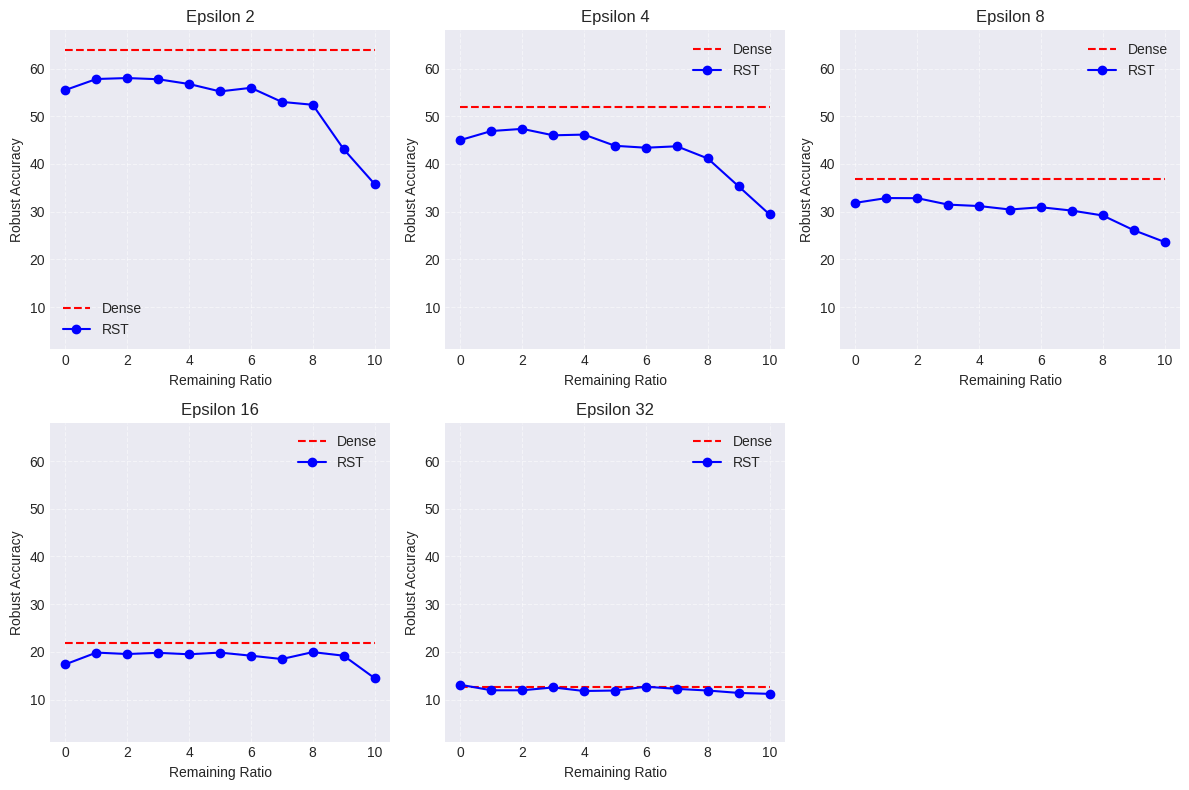

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

# Sample data
epsilon_2 =  [55.50, 57.80, 58.00, 57.75, 56.75, 55.20, 55.95, 53.0, 52.4, 43.1, 35.8]
epsilon_4 =  [45.01, 46.90, 47.35, 46.00, 46.15, 43.80, 43.4, 43.7, 41.15, 35.3, 29.42]
epsilon_8 =  [31.85, 32.85, 32.825, 31.475, 31.175, 30.45, 30.925, 30.225, 29.2, 26.125, 23.65]
epsilon_16 = [17.40, 19.85, 19.55, 19.80, 19.50, 19.85, 19.20, 18.5, 19.95, 19.2, 14.5]
epsilon_32 = [13.10, 11.95, 11.95, 12.55, 11.80, 11.90, 12.7, 12.25, 11.9, 11.4, 11.2]

baseline_values = [63.95, 52.00, 36.9, 21.8, 12.55] 

data_sets = [epsilon_2, epsilon_4, epsilon_8, epsilon_16, epsilon_32]

# Create 2x3 grid of plots (for 5 graphs)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

y_min = min(min(data) for data in data_sets) - 10
y_max = max(max(data) for data in data_sets) + 10

for ax, data, baseline, title in zip(axes.flat, data_sets, baseline_values, 
                                     ['Epsilon 2', 'Epsilon 4', 'Epsilon 8', 'Epsilon 16', 'Epsilon 32']):
    ax.plot(np.arange(11), [baseline] * 11, linestyle='--', label='Dense', color='red')
    ax.plot(np.arange(11), data, linestyle='-', marker='o', label='RST', color='blue')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Remaining Ratio')
    ax.set_ylabel('Robust Accuracy')
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle='--', alpha=0.5)  # Improved visibility with grid lines

# Hide empty subplot in 2x3 grid
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Natural Accuracy with different Perturbation

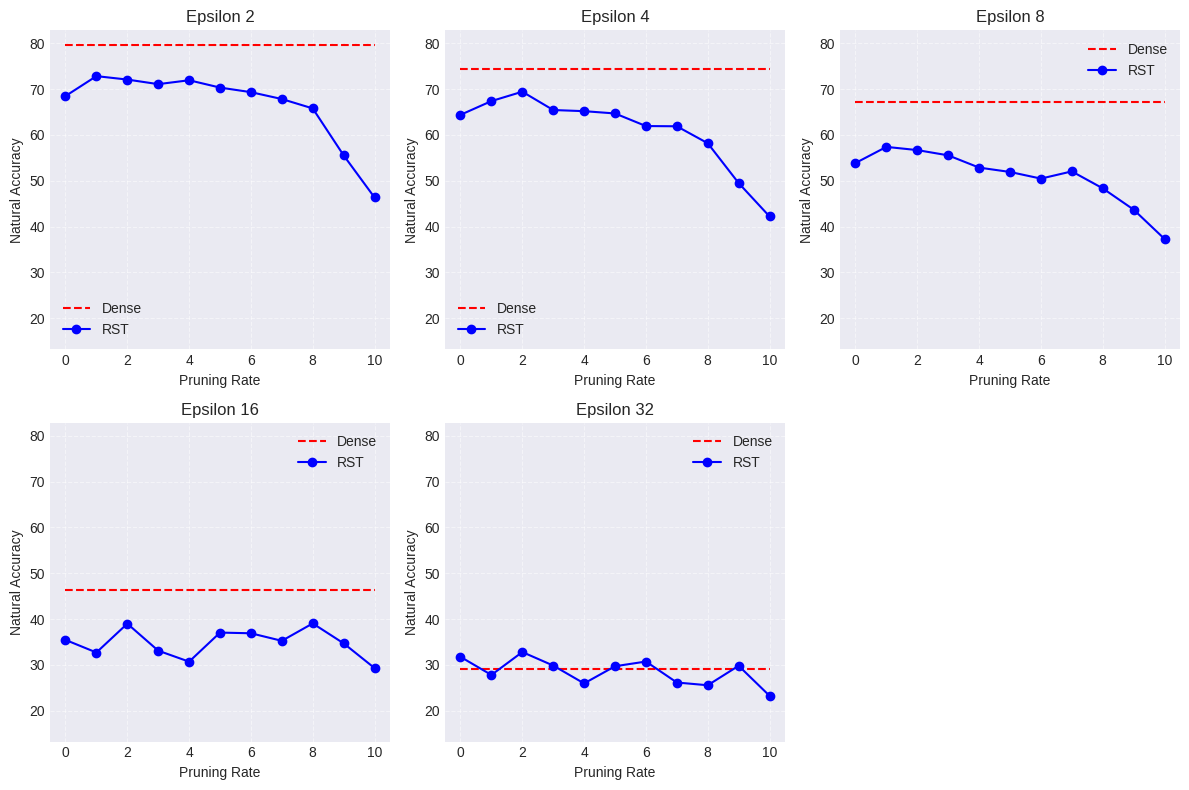

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
epsilon_2 =  [68.5, 72.85, 72.1, 71.1, 71.95, 70.35, 69.35, 67.85, 65.8, 55.55, 46.35]
epsilon_4 =  [64.4, 67.4, 69.45, 65.45, 65.2, 64.7, 61.95, 61.9, 58.2, 49.5, 42.21]
epsilon_8 =  [53.875, 57.4, 56.7, 55.55, 52.875, 51.925, 50.475, 52.05, 48.35, 43.7, 37.3]
epsilon_16 = [35.45, 32.7, 39.0, 33.1, 30.7, 37.05, 36.9, 35.25, 39.05, 34.7, 29.3]
epsilon_32 = [31.75, 27.8, 32.8, 29.85, 25.95, 29.7, 30.73, 26.15, 25.55, 29.8, 23.25]

baseline_values = [79.55, 74.5, 67.1, 46.4, 29.15] 

data_sets = [epsilon_2, epsilon_4, epsilon_8, epsilon_16, epsilon_32]

# Create 2x3 grid of plots (for 5 graphs)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

y_min = min(min(data) for data in data_sets) - 10
y_max = max(max(data) for data in data_sets) + 10

for ax, data, baseline, title in zip(axes.flat, data_sets, baseline_values, 
                                     ['Epsilon 2', 'Epsilon 4', 'Epsilon 8', 'Epsilon 16', 'Epsilon 32']):
    ax.plot(np.arange(11), [baseline] * 11, linestyle='--', label='Dense', color='red')
    ax.plot(np.arange(11), data, linestyle='-', marker='o', label='RST', color='blue')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Pruning Rate')
    ax.set_ylabel('Natural Accuracy')
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle='--', alpha=0.5)  # Improved visibility with grid lines
    
# Hide empty subplot in 2x3 grid
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Train 20% and Test 100%

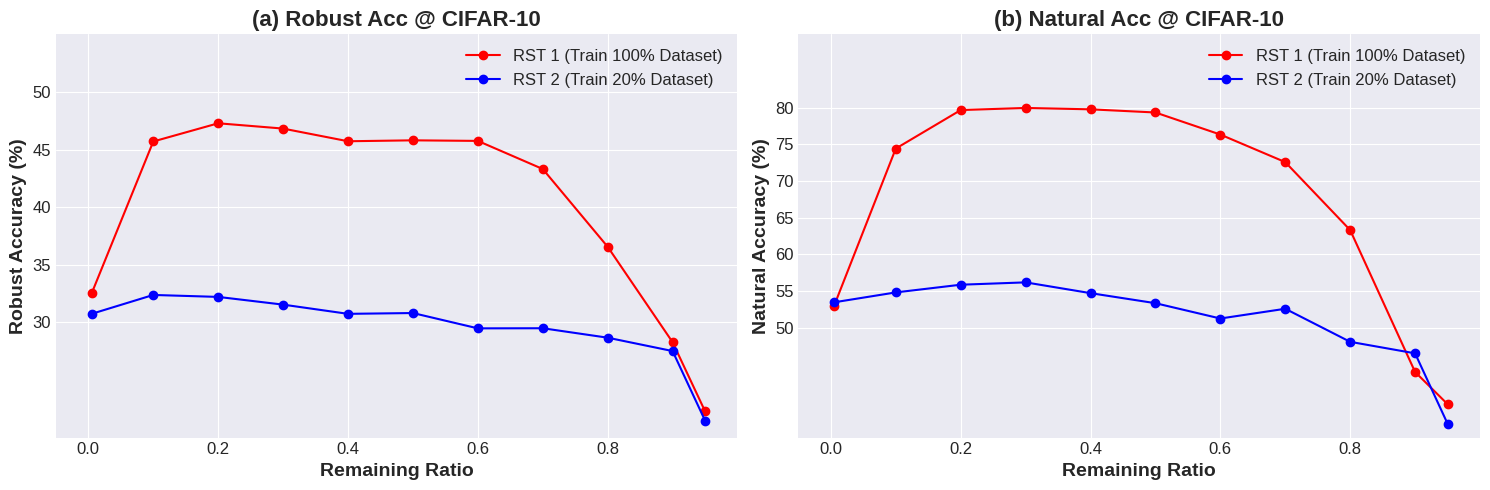

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define data for the plot
remaining_ratio = [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
robust_acc1 = [32.51, 45.7, 47.28, 46.82, 45.72, 45.8, 45.75, 43.31, 36.56, 28.28, 22.29]
natural_acc1 = [52.98, 74.42, 79.67, 79.96, 79.77, 79.34, 76.33, 72.57, 63.3, 43.95, 39.56]

robust_acc2 = [30.74, 32.38, 32.21, 31.54, 30.74, 30.81, 29.48, 29.49, 28.67, 27.51, 21.48]
natural_acc2 = [53.45, 54.8, 55.85, 56.17, 54.7, 53.33, 51.24, 52.57, 48.06, 46.49, 36.9]

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Robust Accuracy
ax1.plot(remaining_ratio, robust_acc1, 'r-o', label='RST 1 (Train 100% Dataset)')
ax1.plot(remaining_ratio, robust_acc2, 'b-o', label='RST 2 (Train 20% Dataset)')
ax1.set_title("(a) Robust Acc @ CIFAR-10", fontsize=16, fontweight='bold')
ax1.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
ax1.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
ax1.set_xlim(-0.05, 1)
ax1.set_ylim(20, 55)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_yticks(np.arange(30, 51, 5))
ax1.set_xticks(np.arange(0, 1, 0.2))
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Natural Accuracy
ax2.plot(remaining_ratio, natural_acc1, 'r-o', label='RST 1 (Train 100% Dataset)')
ax2.plot(remaining_ratio, natural_acc2, 'b-o', label='RST 2 (Train 20% Dataset)')
ax2.set_title("(b) Natural Acc @ CIFAR-10", fontsize=16, fontweight='bold')
ax2.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
ax2.set_ylabel("Natural Accuracy (%)", fontsize=14, fontweight='bold')
ax2.set_xlim(-0.05, 1)
ax2.set_ylim(35, 90)
ax2.grid(True)
ax2.legend(fontsize=12)
ax2.set_yticks(np.arange(50, 85, 5))
ax2.set_xticks(np.arange(0, 1, 0.2))
ax2.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()


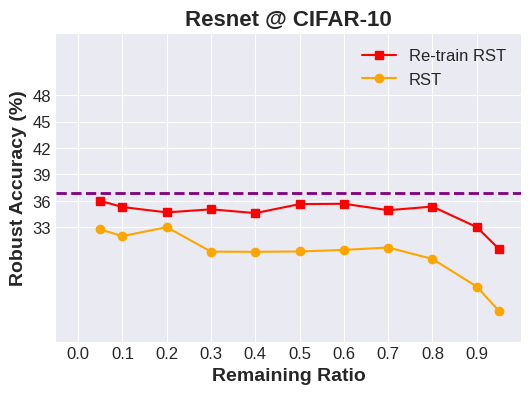

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
remaining_ratio = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
rst = [32.74, 31.99, 33.0, 30.22, 30.2, 30.24, 30.42, 30.69, 29.39, 26.25, 23.48]
retrain_rst = [35.99, 35.29, 34.68, 35.03, 34.6, 35.62, 35.66, 34.93, 35.34, 33.01, 30.54]

# Create the plot with different initialization methods
fig, ax = plt.subplots(figsize=(6, 4))

# Plot Robust Accuracy for different initialization methods
ax.plot(remaining_ratio, retrain_rst, marker='s', linestyle='-', color='red', label='Re-train RST')
ax.plot(remaining_ratio, rst, marker='o', linestyle='-', color='orange', label='RST')
ax.axhline(y=36.9, color='purple', linestyle='--', linewidth=2)

ax.set_title("Resnet @ CIFAR-10", fontsize=16, fontweight='bold')
ax.set_xlabel("Remaining Ratio", fontsize=14, fontweight='bold')
ax.set_ylabel("Robust Accuracy (%)", fontsize=14, fontweight='bold')
ax.set_xlim(-0.05, 1)
ax.set_ylim(20, 55)
ax.grid(True)
ax.legend(fontsize=12)
ax.set_yticks(np.arange(33, 51, 3))
ax.set_xticks(np.arange(0, 1, 0.1))

ax.tick_params(axis='both', which='major', labelsize=12)